In [1]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Make RBC Model](#chapter1)
    * [Model Equations](#section_1_1)
    * [Find Steady State, Solve the Model](#section_1_2)
* [Get Italy data](#chapter2)
* [Preprocessing the data](#chapter3)
    * [Log-Transforming of the Data](#section_3_1)
    * [Detrending the Data](#section_3_2)
    * [Detrending the Data](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [MLE Kalman Filter Prediction](#section_4_1)
    * [Kalman Smoother output](#section_4_2)
    * [Impulse response](#section_4_3)

In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend

# from TimeSeriesTools.stats import ADF_test_summary
# from TimeSeriesTools.transformers import DetrendTransformer, LogTransformer

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Make RBC Model <a class="anchor" id="chapter1"></a>

In [3]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc.gnc'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



### Model Equations  c

In [4]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

### Find Steady State, Solve the Model <a class="anchor" id="section_1_2"></a>

In [5]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.0823547763477462e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [6]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


## Get Italy data <a class="anchor" id="chapter2"></a>

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [7]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

data.drop(["X", "Z"], axis=1, inplace=True)

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In [8]:
# check for na
print("NaNs \n", data.isna().sum())
df = data.copy()

NaNs 
 Y     0
I     0
r     0
C     0
w    36
L     0
dtype: int64


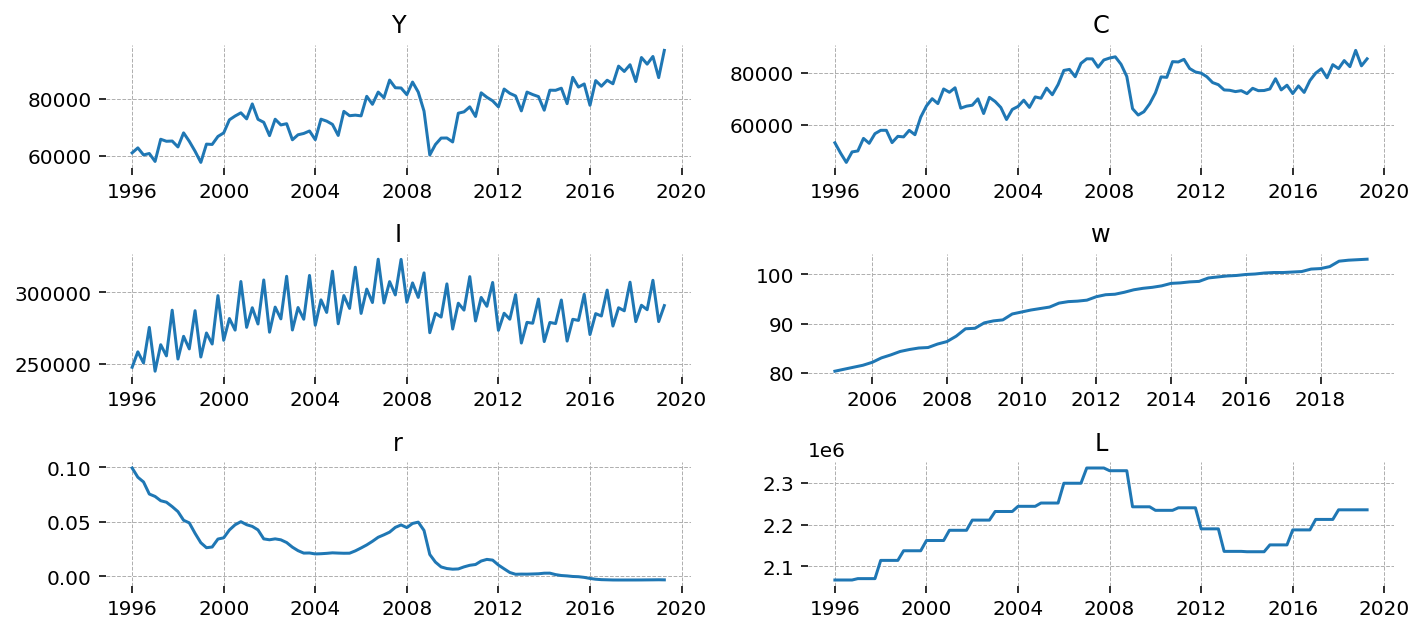

In [9]:
# raw data
plot_df(data)

### Log-transformation <a class="anchor" id="section_3_1"></a>

In [10]:
df = data.copy()

In [11]:
# log transform
for col in df.columns:
    df[col] = apply_func(df[col], func=np.log1p)

Raw data is log transformed, thus somehow equalised in scale

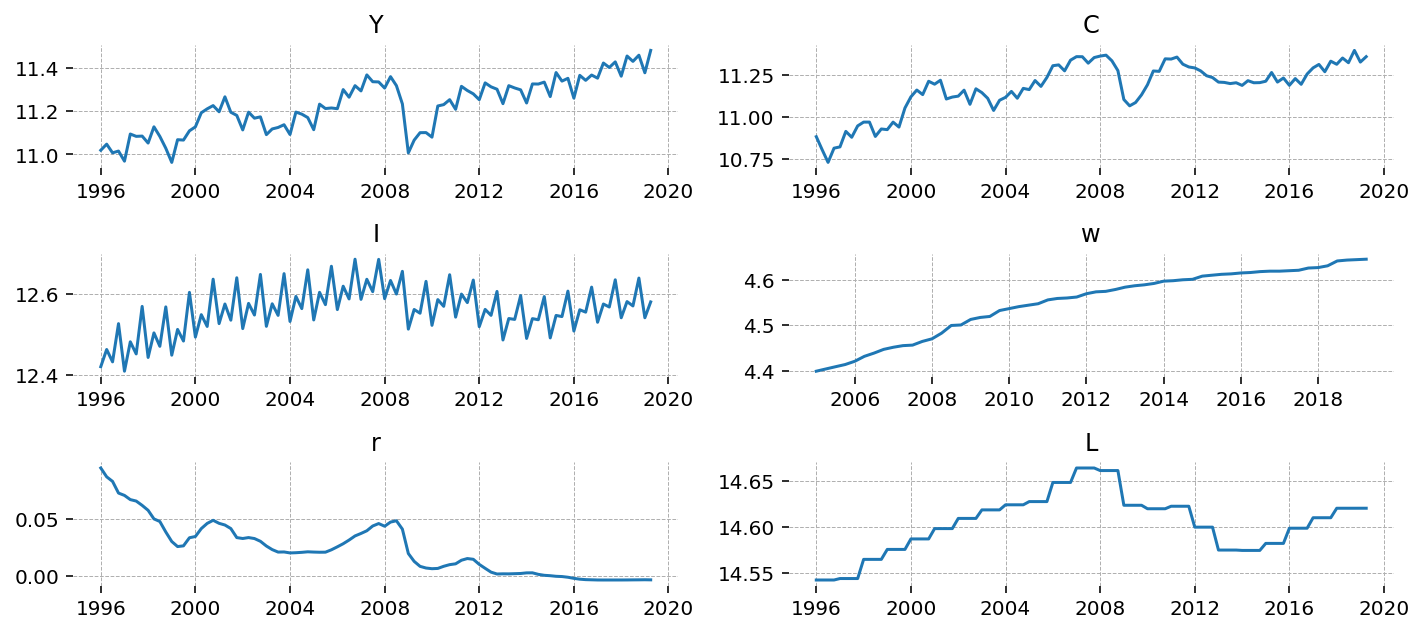

In [12]:
plot_df(df)

### Deseasonalise the Data <a class="anchor" id="section_3_2"></a>

4

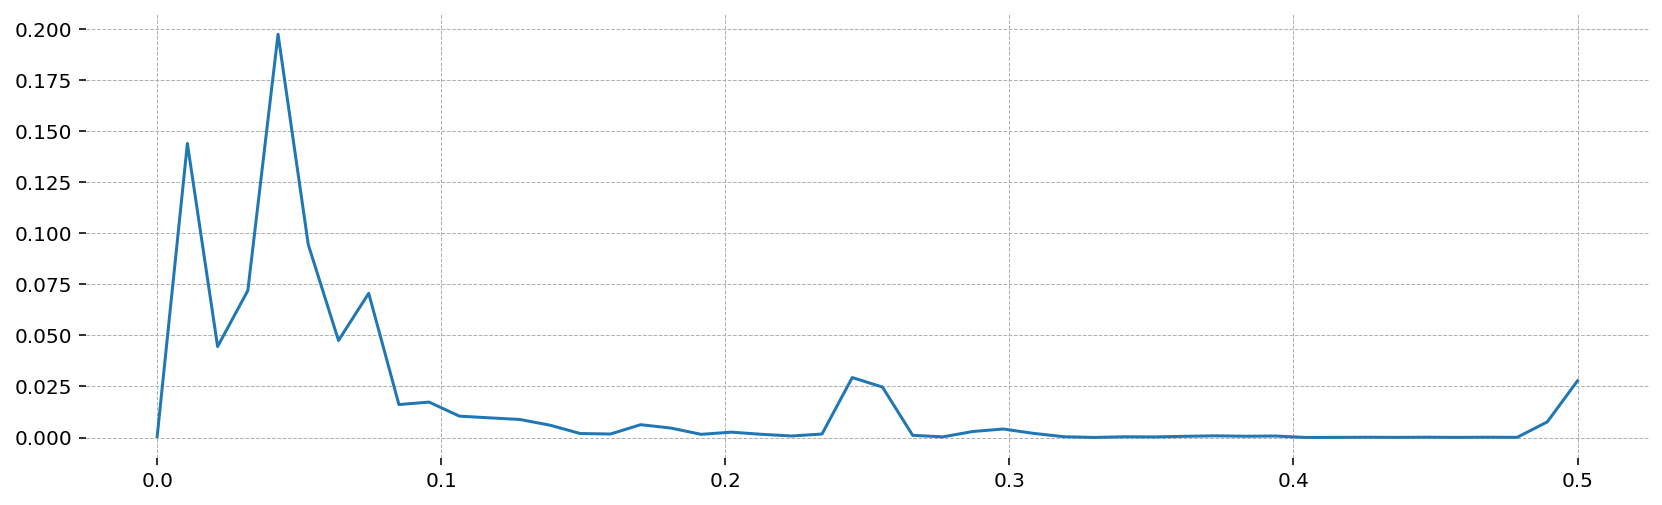

In [15]:
from scipy.signal import periodogram

freq, Pxx = periodogram(df.Y.dropna(), window='triang')
plt.plot(freq, Pxx)
Pxx.argmax()

In [16]:
desea_cols = ['Y', 'I', 'C', 'w', 'r', 'L']
for col in desea_cols:
    df[col] = get_seasonal_hp(df[col], lamb=6.25, skipna=True, )

For deseasonalisation we chose the Hodrick-Prescott filter, which identifies the underlying trend

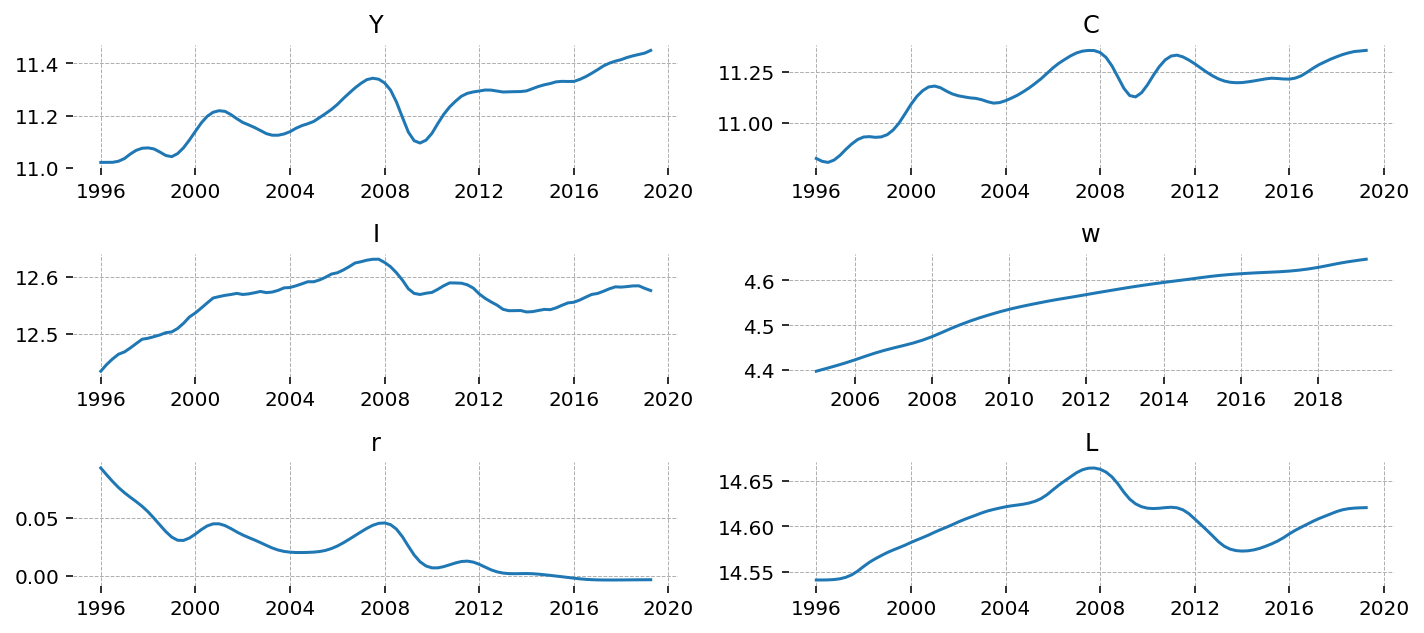

In [17]:
plot_df(df)

### Detrend the Data <a class="anchor" id="section_3_3"></a>

The HP filter identified the underlying trend. Yet the trend is by nature non-stationary, thus not suitable to most statistical procedures. For detrending we use a 2nd order polynomial detrender.

In [18]:
for col in df:
    df[col] = poly_detrend(df[col], poly_order=2, skipna=True)

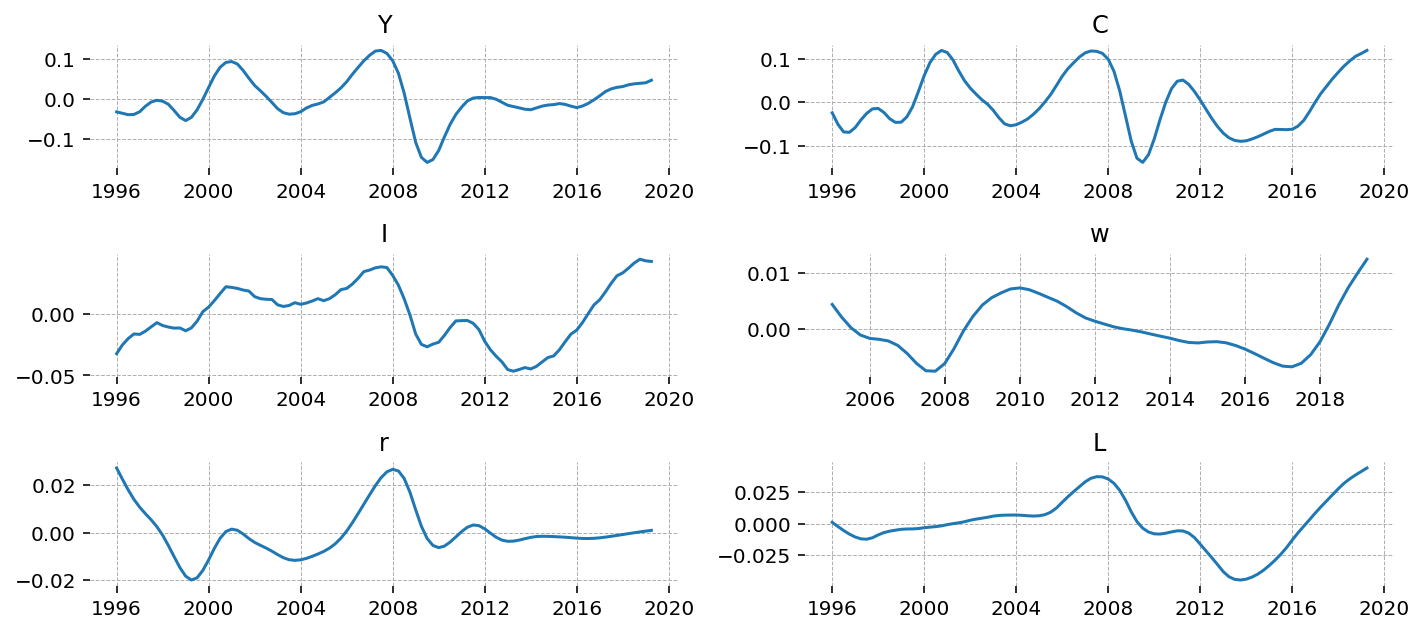

In [19]:
plot_df(df)

### Check stationarity after tranformation <a class="anchor" id="section_3_3"></a>

In [20]:
for col in df.columns:
    arr_adf(df[col], skipna=True)

Y  p-val: 0.061993224471221624,  reject: False
I  p-val: 0.08987343643899898,  reject: False
r  p-val: 0.022044646256555563,  reject: True
C  p-val: 0.13646307921583978,  reject: False
w  p-val: 0.10073249656360672,  reject: False
L  p-val: 0.03787003151108633,  reject: True


## Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [87]:
# assign date freq
df = df.asfreq("QS")

In [88]:
df.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,-0.032228,-0.032272,0.027330,-0.024277,NaN,0.000964
1996-04-01,-0.035615,-0.025139,0.022626,-0.050766,NaN,-0.002330
1996-07-01,-0.039134,-0.020012,0.018144,-0.068207,NaN,-0.005474
1996-10-01,-0.038581,-0.016176,0.014054,-0.068996,NaN,-0.008296
1997-01-01,-0.031839,-0.016541,0.010737,-0.057937,NaN,-0.010559


In [89]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [90]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52, 'delta':0.01} 
rbc.free_param_dict.update(calibrated_params)

In [91]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# NOTE: We have to change this parameters probably

param_start_dict = {'sigma_C':1.5, 
                    'sigma_L':2.0,
#                     'alpha':0.5,
                    'rho_A':0.85}

shock_start_dict = {
    'epsilon_A':0.5
}

noise_start_dict = {
#     'Y':0.01,
    'C':0.02,
    'L':0.05,
    'I':0.02,
    'r':0.03,
    'w':0.1
}

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
    'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-4, high=0.99, slope=1),
#     'alpha':IntervalTransformer(low=0.1, high=0.80, slope=1)
}

mle_mod = MLEModel(df,
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [92]:
mle_res = mle_mod.fit(method='nm', maxiter=10_000)
mle_res = mle_mod.fit(method='lbfgs', maxiter=1_000, start_params=mle_res.params)

Optimization terminated successfully.
         Current function value: -8.774816
         Iterations: 1418
         Function evaluations: 2150


In [93]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'I', 'r', 'C', 'w', 'L']   No. Observations:                   94
Model:                                  DSGEModel   Log Likelihood                 284.542
Date:                            Fri, 02 Dec 2022   AIC                           -551.083
Time:                                    10:13:53   BIC                           -528.194
Sample:                                01-01-1996   HQIC                          -541.837
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma_C              1.0500     32.092      0.033      0.974     -61.849      63.949
sigma_L             10.0000    656.656      0.015      0.988   -1277.023    1297.023
rho_A                0.9900      0.144      6.887      0.000       0.708       1.272
sigma2.epsilon_A     0.0197      0.144      0.137      0.891      -0.263       0.302
sigma2.C             0.1961      1.873      0.105      0.917      -3.474       3.866
sigma2.L             0.0551      0.841      0.066      0.948      -1.593       1.704
sigma2.I             0.0668      0.733      0.091      0.927      -1.369       1.503
sigma2.r             0.0592      0.039      1.513      0.130      -0.017       0.136
sigma2.w             0.0199      0.299      0.067      0.947      -0.566       0.606
=============================================================================================================================
Ljung-Box (L1) (Q):     79.80, 87.57, 88.95, 85.81, 88.16, 90.51   Jarque-Bera (JB):   71.79, 23.86, 47.25, 4.20, 43.53, 0.86
Prob(Q):                      0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):               0.00, 0.00, 0.00, 0.12, 0.00, 0.65
Heteroskedasticity (H):       0.12, 0.12, 0.22, 2.43, inf, 17.13   Skew:                 -1.29, 0.77, 1.19, 0.12, 0.55, -0.21
Prob(H) (two-sided):          0.00, 0.00, 0.00, 0.02, 0.00, 0.00   Kurtosis:               6.42, 4.92, 5.52, 1.99, 6.15, 2.78
=============================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

## MLE Kalman Filter Prediction <a class="anchor" id="section_4_1"></a>

In [94]:
def plot_sm_results(res, filter_output='predicted'):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = mle_res.states.predicted.columns
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(mle_res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(mle_res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            mle_res.data.orig_endog[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

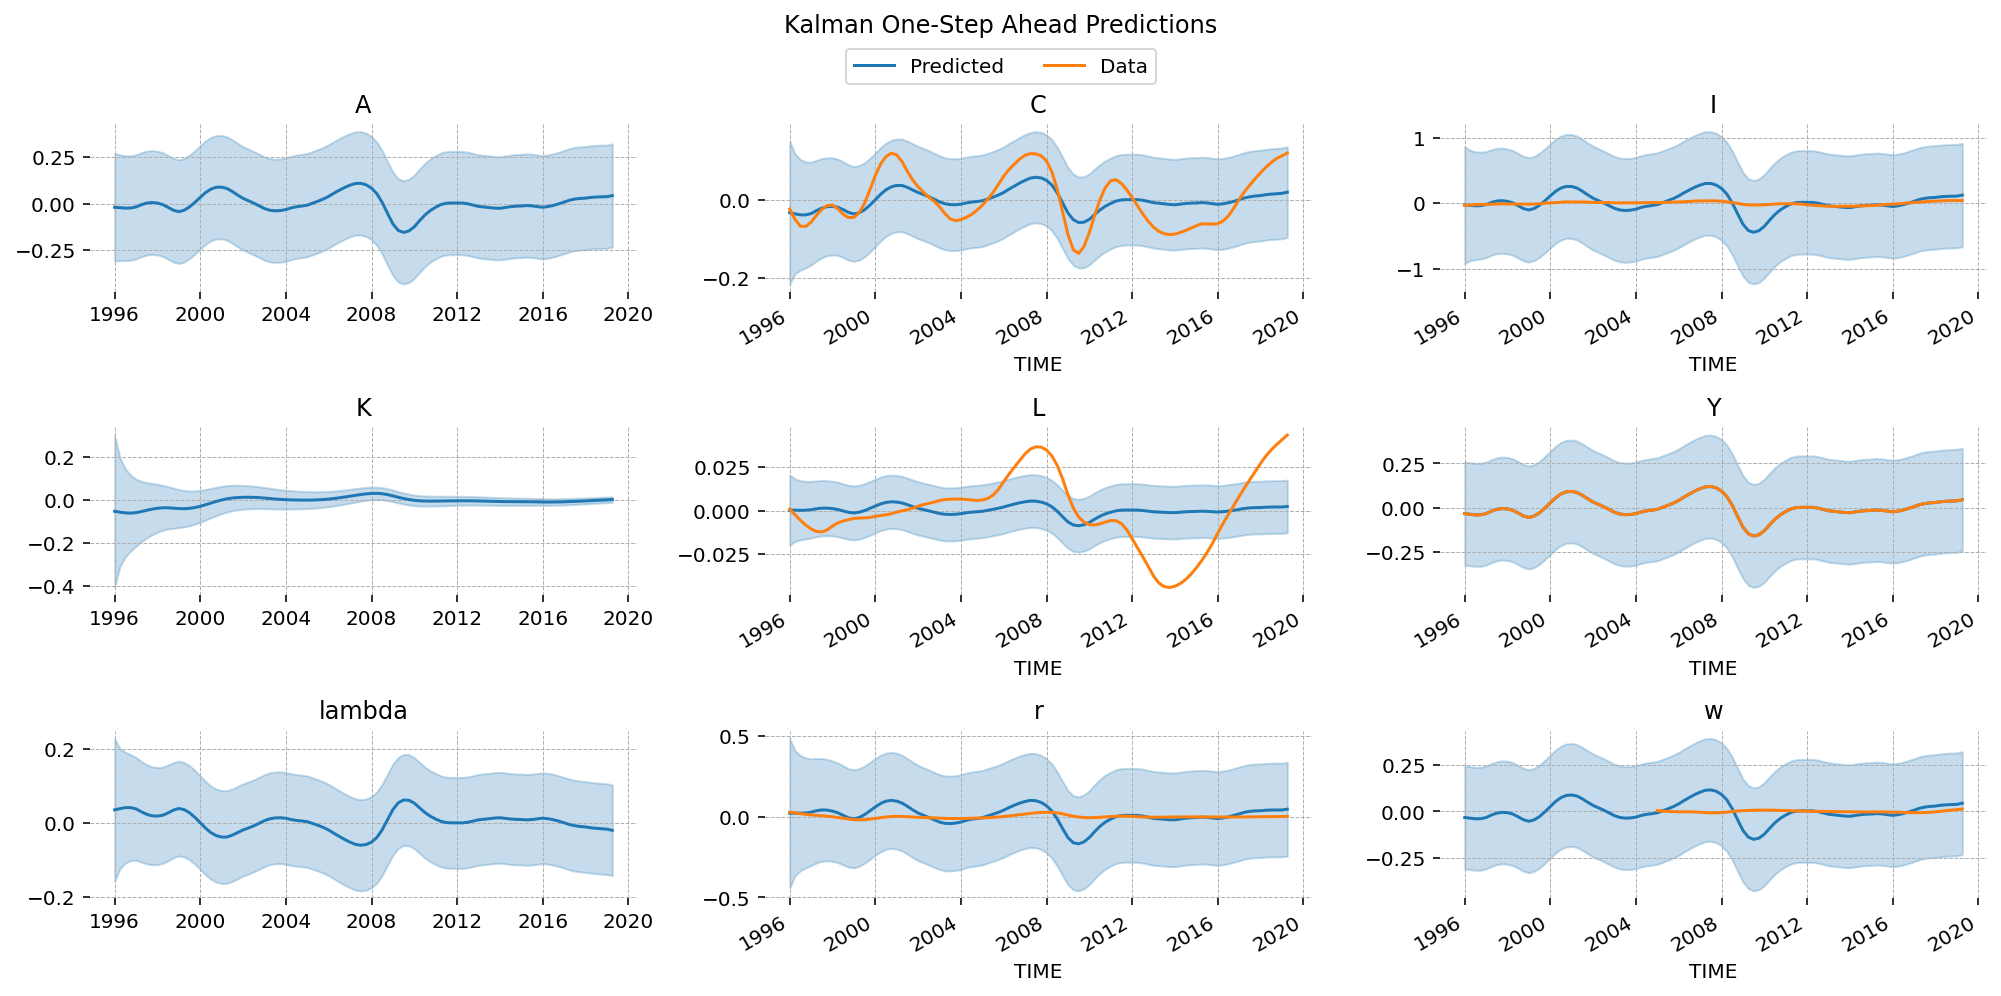

In [95]:
plot_sm_results(mle_res)

## Kalman Smoother output <a class="anchor" id="section_4_2"></a>

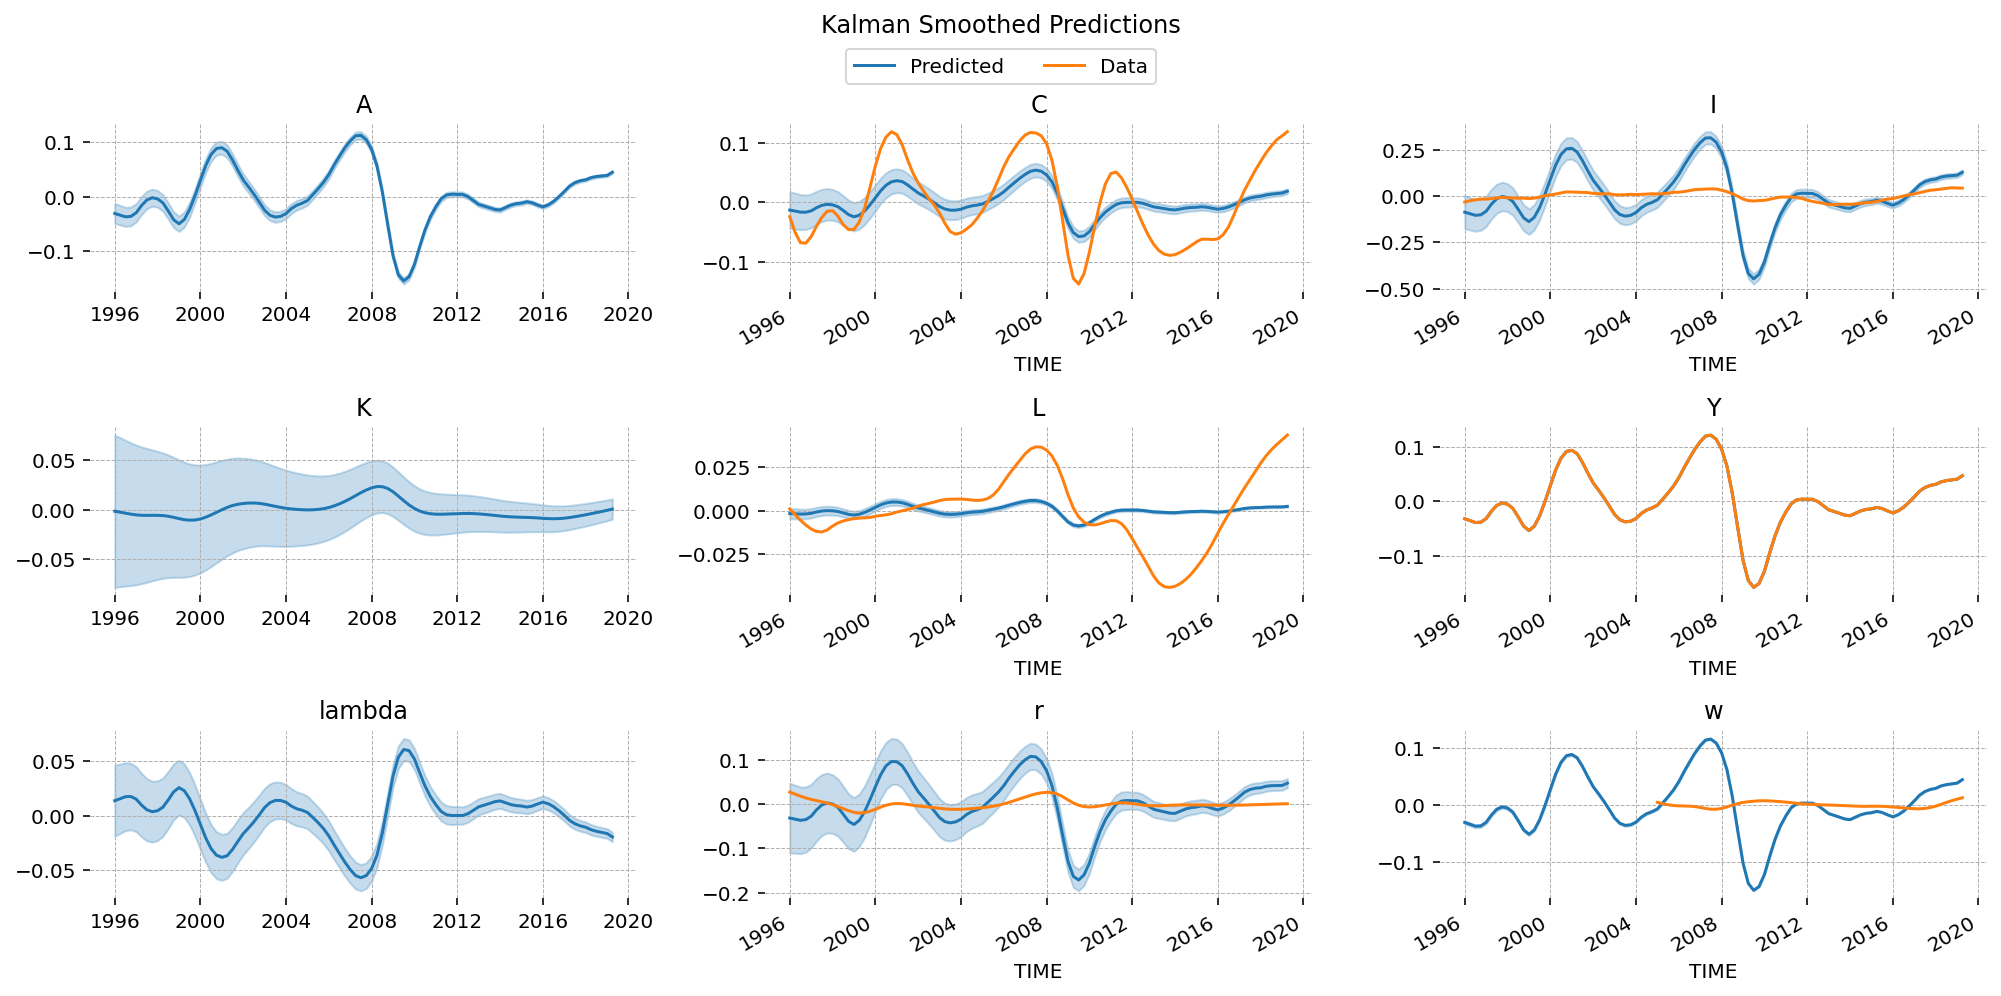

In [96]:
plot_sm_results(mle_res, 'smoothed')

## Impulse response <a class="anchor" id="section_4_3"></a>

In [97]:
irf_df = mle_res.impulse_responses(impulse=0, steps=1_000, orthogonalized=False)
irf_df.index = pd.MultiIndex.from_product([irf_df.index, ['epsilon_A']], names=['Time', 'Shocks'])
irf_df.columns.name = 'Variables'

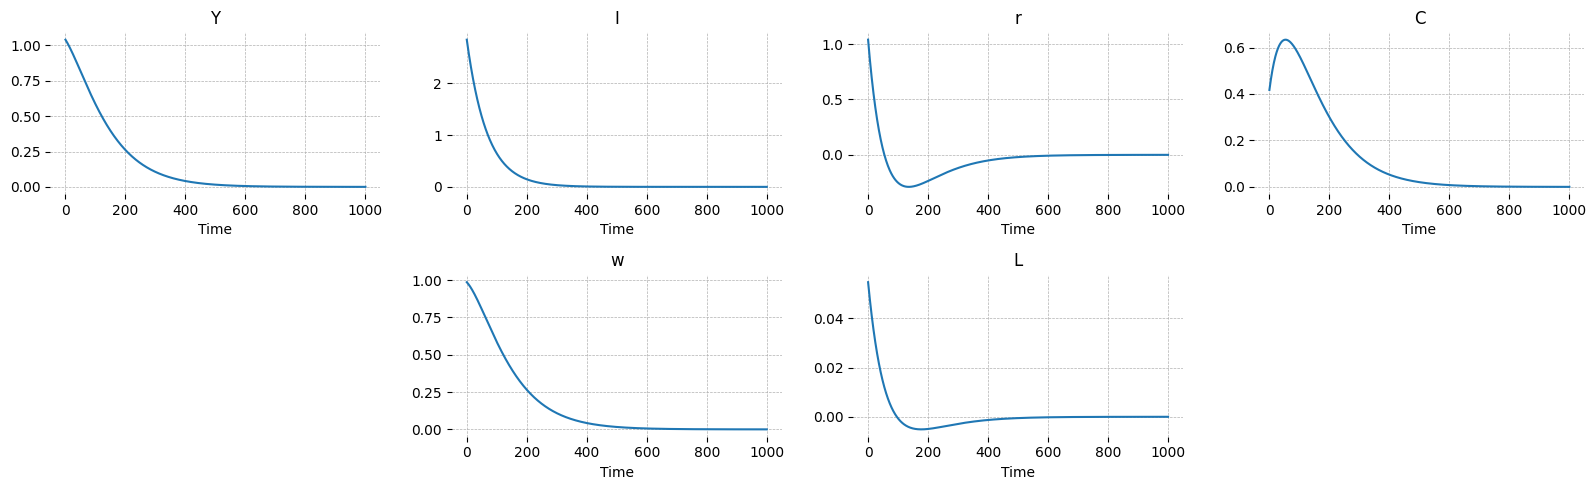

In [98]:
fig = gp.plot_irf(irf_df.T, shocks_to_plot='epsilon_A', figsize=(16,5))
plt.show()